In [56]:
import numpy as np
from tqdm import tqdm

In [2]:
class Venus:
    
    def __init__(
        self,
        inj_limits=[175, 185],
        mid_limits=[145, 155],
        ext_limits=[135, 145],
        beam_range=[50, 100],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )

    def _rescale_output(self, output):
        """himmelblau4 returns values betwen 0 and 4899 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 4899) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self._rescale_output(self._himmelblau4(*self._rescale_inputs(self.currents)))

    @staticmethod
    def _himmelblau4(w, x, y):
        """A funky 4 dimensional parameter space with a bunch of local minima."""
        return (
            (w**2 + x + y - 11)**2 +
            (w + x**2 + y - 7)**2 +
            (w + x + y**2 - 5)**2
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [3]:
venus = Venus(jitter=0.05)

set the currents and read the beam value

In [4]:
venus.set_mag_currents(185, 155, 145)
bc = venus.get_beam_current()
print(bc)

50.76179269938608


if currents are outside the range a `ValueError` is raised and can be captured.

In [5]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

In [6]:
venus._himmelblau4(6, 6, 6)

4899

# Bayesian Optimization

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    v = -venus._himmelblau4(A, B, C)
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [0, 185], "B": [0, 155], "C": [0, 145]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 38)
optimizer.maximize(init_points = 5, n_iter = 15)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        | -7.097e+0 |  71.18    |  133.3    |  136.9    |
|  2        | -4.52e+08 |  130.0    |  98.21    |  87.86    |
|  3        | -1.787e+0 |  37.02    |  60.05    |  37.55    |
|  4        | -2.071e+0 |  13.8     |  43.55    |  63.57    |
|  5        | -4.387e+0 |  89.4     |  134.6    |  76.8     |
|  6        | -195.0    |  0.0      |  0.0      |  0.0      |
|  7        | -2.084e+0 |  16.83    |  40.96    |  64.39    |
|  8        | -1.171e+0 |  185.0    |  0.0      |  0.0      |
|  9        | -5.769e+0 |  0.0      |  155.0    |  0.0      |
|  10       | -4.419e+0 |  0.0      |  0.0      |  145.0    |
|  11       | -6.169e+0 |  0.0      |  49.9     |  0.0      |
|  12       | -4.646e+0 |  0.0      |  0.0      |  46.47    |
|  13       | -1.767e+0 |  185.0    |  155.0    |  0.0      |
|  14       | -1.63e+09 |  185.0    |  0.0      |  145.0    |
|  15   

In [127]:
# try a certain times and see how many converges
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    rand_adder = int(rand_adder)
    results = []
    for i in tqdm(range(N)):
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0,
                                         random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa)
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))

## Simple Trial

100%|███████████████████████████████████████████| 20/20 [00:05<00:00,  3.95it/s]


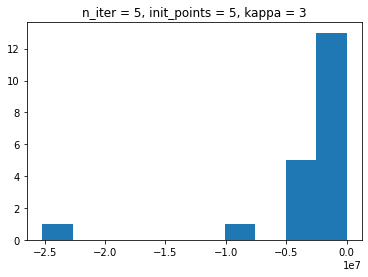

In [129]:
trial(20, n_iter = 5, init_points = 5, kappa = 3, verbose = 0, rand_adder = 1e2)

## Making sure our method is better than random

100%|███████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


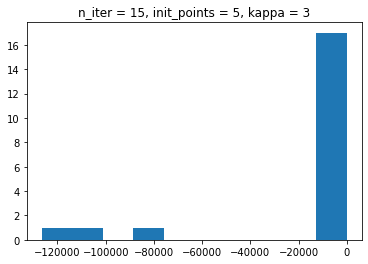

In [109]:
trial(20, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 2e2)

100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.27it/s]


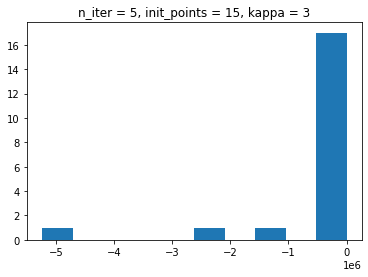

In [97]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(20, n_iter = 5, init_points = 15, kappa = 3, verbose = 0, rand_adder = 3e2)

## Trying out kappa

100%|███████████████████████████████████████████| 30/30 [00:52<00:00,  1.75s/it]


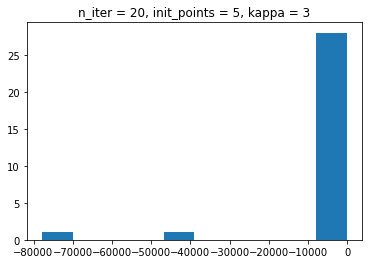

In [115]:
trial(30, n_iter = 30, init_points = 5, kappa = 3, verbose = 1, rand_adder = 5e2)

100%|███████████████████████████████████████████| 30/30 [01:33<00:00,  3.11s/it]


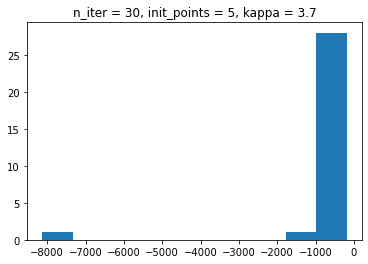

In [114]:
trial(30, n_iter = 30, init_points = 5, kappa = 3.7, verbose = 1, rand_adder = 7e2)

100%|███████████████████████████████████████████| 30/30 [01:26<00:00,  2.87s/it]


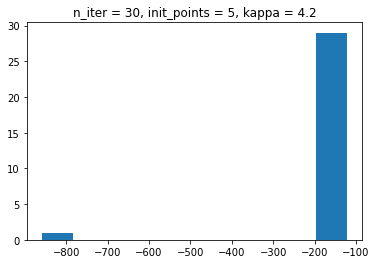

In [116]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1, rand_adder = 8e2)

100%|███████████████████████████████████████████| 30/30 [01:27<00:00,  2.92s/it]


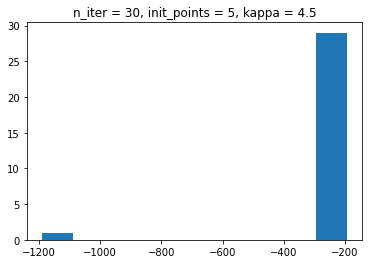

In [118]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.5, verbose = 1, rand_adder = 9e2)

## Increase n_iter

100%|███████████████████████████████████████████| 30/30 [04:09<00:00,  8.30s/it]


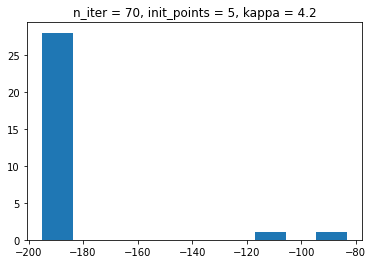

[-83.41717482507394, -108.00906940923039, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0]


In [130]:
trial(30, n_iter = 70, init_points = 5, kappa = 4.2, verbose = 1, rand_adder = 1e3)

100%|███████████████████████████████████████████| 30/30 [04:24<00:00,  8.83s/it]


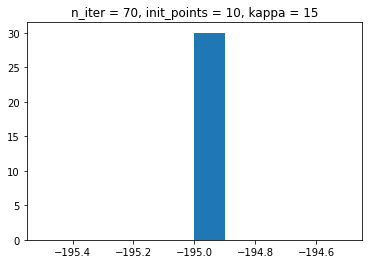

[-195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0]


In [142]:
trial(30, n_iter = 70, init_points = 10, kappa = 15, verbose = 1, rand_adder = 1.1e3)

100%|███████████████████████████████████████████| 30/30 [04:37<00:00,  9.25s/it]


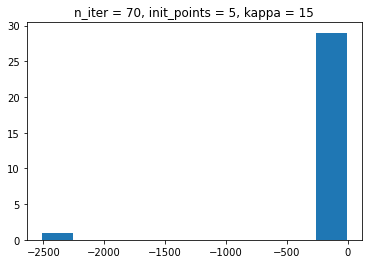

[-9.460997841425904, -194.99999999999991, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -2510.300282621165]


In [137]:
trial(30, n_iter = 70, init_points = 5, kappa = 15, verbose = 1, rand_adder = 1.2e3)

In [ ]:
# TODO: guide optimization to known good points

In [65]:
# unused. Potentially for future tests
# from deap import benchmarks

# def ackley_arg0(sol):
#     return benchmarks.ackley(sol)[0]

In [66]:
# ackley_arg0((0,0,0))